In [2]:
import cv2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

Using TensorFlow backend.


In [5]:
!pip install tqdm

In [6]:
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [7]:
face_images = glob.glob('lfw/**/*.jpg')

In [8]:
# reducing size of all images
all_images = []

for i in tqdm(face_images):
    img = image.load_img(i, target_size=(40,40,3))
    img = image.img_to_array(img)
    img = img/255.
    all_images.append(img)

100%|███████████████████████████████████████████████████████████████████████████| 13233/13233 [00:31<00:00, 417.38it/s]


In [9]:
all_images = np.array(all_images)

train_x, val_x = train_test_split(all_images,random_state=32, test_size=0.1)

In [10]:
# function to reduce resolution of input images

def pixelate_image(image,scale_percent=40):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    
    small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    
    width = int(small_image.shape[1] * 100/ scale_percent)
    height = int(small_image.shape[0] * 100 / scale_percent)
    dim = (width, height)
    
    low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)
    return low_res_image

In [11]:
train_x_px = []

for i in range(train_x.shape[0]):
    temp = pixelate_image(train_x[i, :,:,:])
    train_x_px.append(temp)

train_x_px = np.array(train_x_px)

val_x_px = []

for i in range(val_x.shape[0]):
    temp = pixelate_image(val_x[i,:,:,:])
    val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [12]:
# Model building 

Input_img = Input(shape=(40,40,3))

x1 = Conv2D(256, (3,3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x1)
x2 = MaxPool2D((2,2))(x2)
encoded = Conv2D(64, (3,3), activation='relu', padding='same')(x2)

x3 = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2,2))(x3)
x2 = Conv2D(128,(3,3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3,3),activation='relu', padding='same')(x2)
decoded = Conv2D(3,(3,3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

W0331 08:53:31.894346  7828 deprecation.py:506] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 40, 40, 64)        0     

In [14]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')

a_e = autoencoder.fit(train_x_px, train_x, epochs=25, batch_size=256,shuffle=True, validation_data=(val_x_px, val_x), callbacks=[early_stopper])

Train on 11909 samples, validate on 1324 samples
Epoch 1/25
11909/11909 [==============================] - 54s 5ms/sample - loss: 0.0347 - val_loss: 0.0124
Epoch 2/25
11909/11909 [==============================] - 41s 3ms/sample - loss: 0.0108 - val_loss: 0.0095
Epoch 3/25
11909/11909 [==============================] - 41s 3ms/sample - loss: 0.0091 - val_loss: 0.0085
Epoch 4/25
11909/11909 [==============================] - 41s 3ms/sample - loss: 0.0087 - val_loss: 0.0078
Epoch 5/25
11909/11909 [==============================] - 41s 3ms/sample - loss: 0.0077 - val_loss: 0.0076
Epoch 6/25
11909/11909 [==============================] - 41s 3ms/sample - loss: 0.0074 - val_loss: 0.0073
Epoch 7/25
11909/11909 [==============================] - 41s 3ms/sample - loss: 0.0075 - val_loss: 0.0071
Epoch 8/25
11909/11909 [==============================] - 41s 3ms/sample - loss: 0.0070 - val_loss: 0.0070
Epoch 9/25
11909/11909 [==============================] - 41s 3ms/sample - loss: 0.0069 - val_l

In [15]:
predictions = autoencoder.predict(val_x_px)

W0331 09:06:39.663496  7828 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0331 09:06:39.703167  7828 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0331 09:06:39.721024  7828 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0331 09:06:39.745337  7828 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


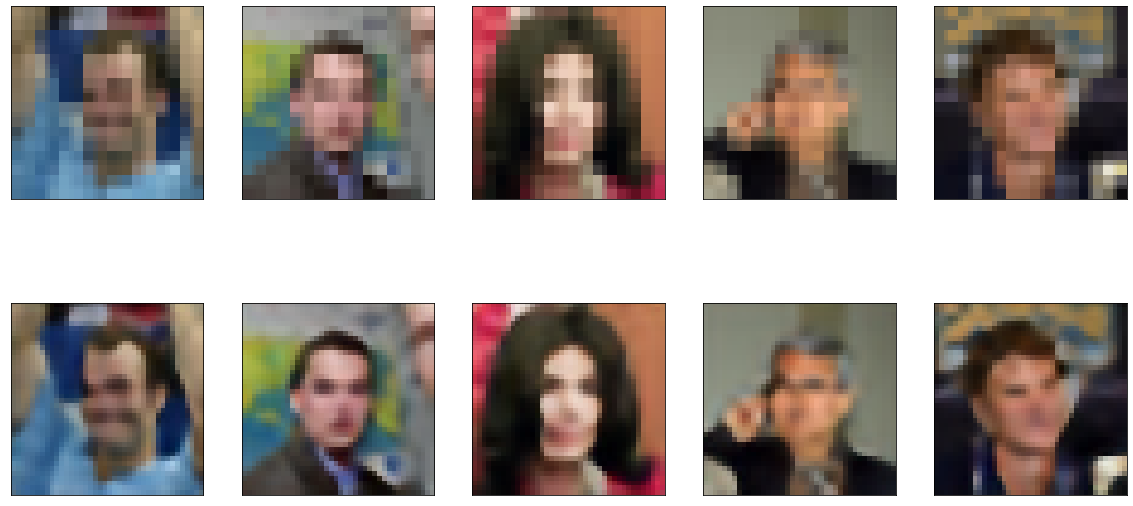

In [16]:
n = 5
plt.figure(figsize = (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_x_px[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2,n, i+1+n)
    plt.imshow(predictions[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()